In [167]:


#       1) d R(t) / dt = -sigma * R(t) + R*(t)
#      2) d PDE(t) / dt = opsin(t) - phi * PDE(t) + eta
#       3) d cGMP(t) / dt = S(t) - PDE(t) * cGMP(t)
#       4) d Ca(t) / dt = q * I(t) - beta * Ca(t)
#       5) d Ca_slow(t) / dt = - beta_slow * (Ca_slow(t) - Ca(t))
#       6) S(t) = smax / (1 + (Ca(t) / kGc)^n)
#       7) I(t) = k * cGMP(t) ^ h / (1 + Ca_slow / Ca_dark)

#from "Predicting and Manipulating Cone Responses to Naturalistic Inputs"





In [2]:
!pip install seaborn

  Using cached pandas-2.2.1-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.9 kB 281.8 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 281.8 kB/s eta 0:00:01
   ------------ -------------------------- 92.2/294.9 kB 403.5 kB/s eta 0:00:01
   ------------ -------------------------- 92.2/294.9 kB 403.5 kB/s eta 0:00:01
   ------------------------- ------------ 194.6/294.9 kB 588.9 kB/s eta 0:00:01
   ------------------------- ------------ 194.6/294.9 kB 588.9 kB/s eta 0:00:01
   ----------------------------- -------- 225.3/294.9 kB 529.7 kB/s eta 0:00:01
   ------------------

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint

# This makes plots show up and look nice
#matplotlib inline
sns.set(context='paper',style='white',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.set_palette('muted')

In [4]:


### Parameters

##constants
Gamma = 10.0 # Gamma     ::  opsin gain factor
sigma = 22 # sigma     ::  opsin decay rate constant (1/s)
phi = 22 # phi       ::  PDE decay rate constant
eta = 2000 # eta       ::  PDE dark activation rate
h= 3.0 # h         ::  cooperativity of cGMP on channel
q= 0.1125 # q         ::  fraction of photocurrent carried by calcium
beta = 9.0 # beta      ::  rate constant of Ca exchange
Smax = 30909 # Smax      ::  maximum cGMP synthesis
Kgc = 0.5 # Kgc       ::  affinity of GC for Ca
m = 4.0 # m         ::  cooperativity of Ca on GC 
betas = 0.4 # betas     ::  decay rate constant of "slow" Ca
k = 0.02 # k         ::  cGMP channel gain constant
Cad= 1 # Cad       ::  Ca in darkness
Id = 80 # Id        ::  dark current
# Pd        ::  dark PDE
Gd= 20 # Gd        ::  dark cGMP



In [11]:

# Time-dependent equations
def dR_dt(R, s):
    return Gamma * s - sigma * R

def dP_dt(R, P):
    return R - phi * P + eta

def dG_dt(S, P, G):
    return S - P * G

def dCa_dt(I, Ca):
    return q * I - beta * Ca

def dCas_dt(Cas, Ca):
    return betas * (Cas - Ca)

# Steady-state equations
def calculate_q(Id, Cad, beta):
    return beta * Id / Cad

def calculate_Smax(Pd, Gd, Kgc, m, Cad):
    return Pd / Gd * (1 + (Cad / Kgc) ** m)

def calculate_Kca(k, Cad, Cas):
    return k / (1 + Cas / Cad)

# Define the function to solve the differential equations
def solve_equations(y, t):
    R, P, G, Ca, Cas, I = y

    # Calculate stimulus at each time point
    s = 10000*np.sin(t * 2 * np.pi)

    S = Smax / (1 + (Ca / Kgc) ** m)
    I = calculate_Kca(k, Cad, Cas) * G ** h

    dRdt = dR_dt(R, s)
    dPdt = dP_dt(R, P)
    dGdt = dG_dt(S, P, G)
    dCadt = dCa_dt(I, Ca)
    dCasdt = dCas_dt(Cas, Ca)

    return [dRdt, dPdt, dGdt, dCadt, dCasdt, I]

# Initial conditions
# Calculate PDE activity in darkness (Pd)
# Pd = Smax * Gd / (1 + (Cad / Kgc) ** m)
Pd = eta / phi

R0 = 0
P0 = Pd
G0 = Gd
Ca0 = Cad
# Cas0 = Cad
Cas0 = Cad/Id*(k*Gd**h - Id)
# Id = -80

# Initial conditions
initial_conditions = np.array([R0, P0, G0, Ca0, Cas0, Id])

# Time points
t = np.linspace(0, 1.0, 1000)  # Adjust time span as needed

# Solve the differential equations
sol = odeint(solve_equations, initial_conditions, t)

# Extract results
R, P, G, Ca, Cas, I = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3], sol[:, 4], sol[:,5]

# Calculate stimulus
s = 10000*np.sin(t * 2 * np.pi)

# Calculate photocurrent
#I = calculate_Kca(k, Cad, Cas) * G ** h


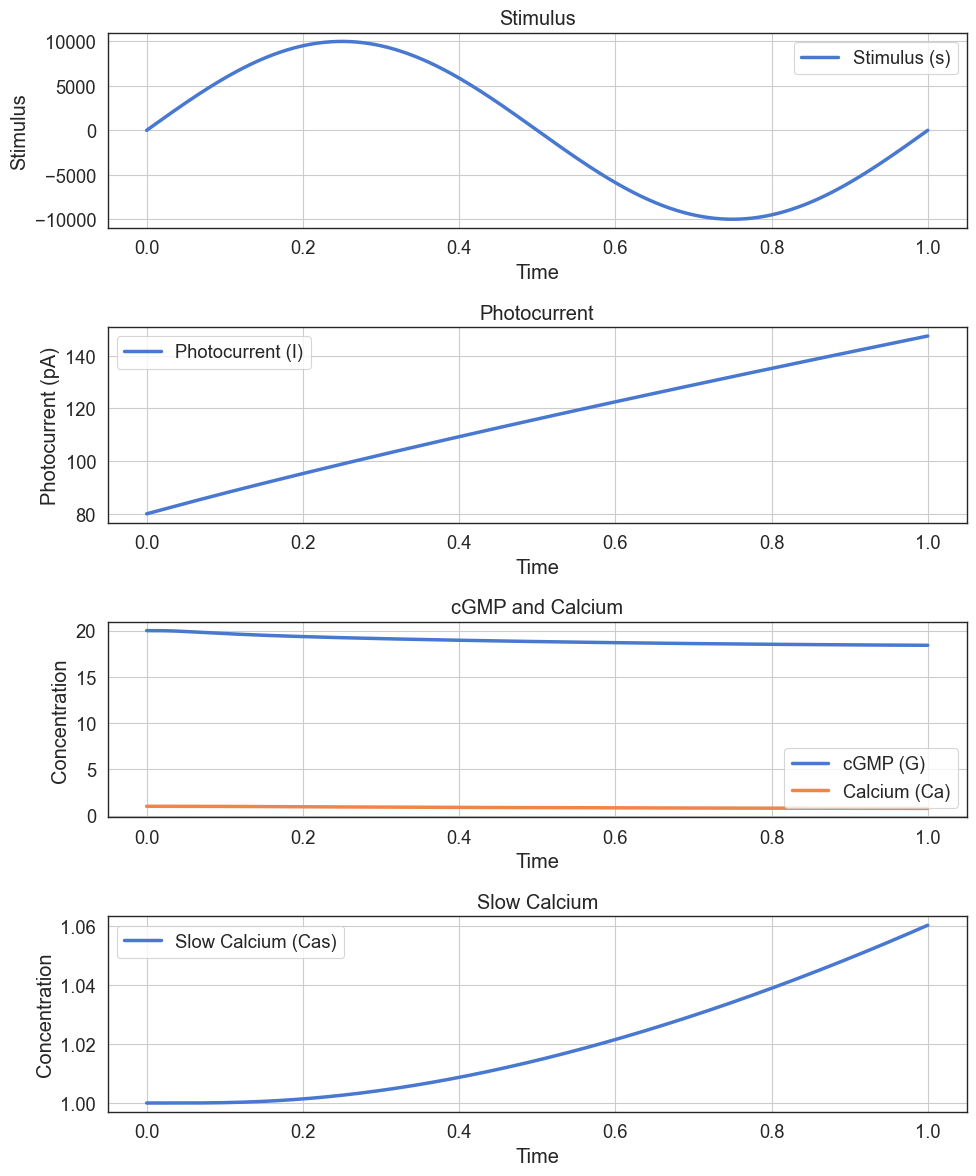

In [12]:

# Plot the results
plt.figure(figsize=(10, 12))

# Plot stimulus
plt.subplot(4, 1, 1)
plt.plot(t, s, label='Stimulus (s)')
plt.xlabel('Time')
plt.ylabel('Stimulus')
plt.title('Stimulus')
plt.legend()
plt.grid(True)

# Plot photocurrent
plt.subplot(4, 1, 2)
plt.plot(t, I, label='Photocurrent (I)')
plt.xlabel('Time')
plt.ylabel('Photocurrent (pA)')
plt.title('Photocurrent')
plt.legend()
plt.grid(True)

# Plot cGMP and Calcium
plt.subplot(4, 1, 3)
plt.plot(t, G, label='cGMP (G)')
plt.plot(t, Ca, label='Calcium (Ca)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('cGMP and Calcium')
plt.legend()
plt.grid(True)

# Plot slow Calcium
plt.subplot(4, 1, 4)
plt.plot(t, Cas, label='Slow Calcium (Cas)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Slow Calcium')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

